**CREDIT:** Adapted from this [notebook](https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/lora_tuning.ipynb).


##### Copyright 2024 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Overview

This notebook walks you through using Keras to perform LoRA fine-tuning on a Google Gemma 2B model using an instruction-answer dataset.

## Setup

### Get access to Gemma and set up your API keys

The instructions are below (if you run into issues, you can refer to the detailed instructions [here](https://ai.google.dev/gemma/docs/setup)).


* Go to [kaggle.com](https://kaggle.com) and create an account.
* Go to the [Gemma model card](https://www.kaggle.com/models/google/gemma) and select **Request Access**. Complete the consent form and accept the terms and conditions.
* Go to the **Account** tab of your Kaggle user profile and select **Create New Token**. This will trigger the download of a `kaggle.json` file containing your Kaggle username and Kaggle API key.
* Open this file using a text editor.
* In Colab, select **Secrets** (🔑) in the left pane.  
- Copy your Kaggle username from the text editor and store it under the name `KAGGLE_USERNAME`.  
- Copy your Kaggle API key from the text editor and store it under the name `KAGGLE_KEY`.

When you are done, it should look like this:



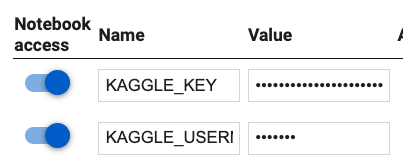

### Select the runtime

To run this notebook, you'll need a T4 GPU.

1. In the upper-right of the Colab window, select the down arrow.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **T4 GPU**.

### Set environment variables

Set environment variables for `KAGGLE_USERNAME` and `KAGGLE_KEY`.

In [ ]:
import os
from google.colab import userdata

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

In [ ]:
from pprint import pprint

### Set the Keras backend and import keras

For this tutorial, we will use JAX as the Keras backend.

In [ ]:
os.environ["KERAS_BACKEND"] = "jax"  # Or "torch" or "tensorflow".
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00"

In [ ]:
import keras

## Load Dataset

We will use the [Databricks Dolly 15k dataset](https://huggingface.co/datasets/databricks/databricks-dolly-15k). This dataset contains 15,000 high-quality human-generated prompt / response pairs specifically designed for fine-tuning LLMs.

In [ ]:
!wget -O databricks-dolly-15k.jsonl https://huggingface.co/datasets/databricks/databricks-dolly-15k/resolve/main/databricks-dolly-15k.jsonl

--2025-03-10 12:14:36--  https://huggingface.co/datasets/databricks/databricks-dolly-15k/resolve/main/databricks-dolly-15k.jsonl
Resolving huggingface.co (huggingface.co)... 54.230.71.2, 54.230.71.28, 54.230.71.103, ...
Connecting to huggingface.co (huggingface.co)|54.230.71.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/34/ac/34ac588cc580830664f592597bb6d19d61639eca33dc2d6bb0b6d833f7bfd552/2df9083338b4abd6bceb5635764dab5d833b393b55759dffb0959b6fcbf794ec?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27databricks-dolly-15k.jsonl%3B+filename%3D%22databricks-dolly-15k.jsonl%22%3B&Expires=1741612476&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0MTYxMjQ3Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy8zNC9hYy8zNGFjNTg4Y2M1ODA4MzA2NjRmNTkyNTk3YmI2ZDE5ZDYxNjM5ZWNhMzNkYzJkNmJiMGI2ZDgzM2Y3YmZkNTUyLzJkZjkwODMzMzhiNGFiZDZiY2ViNTYzNTc2NGRhYjVkODMzYjM5M2I1NTc1OWRmZmIwOT

Let's read the file into a dataframe and take a look at a few examples.

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', 500)
df = pd.read_json("databricks-dolly-15k.jsonl", lines=True)

In [ ]:
df.sample(5)

,instruction,context,response,category
2308,Who recorded the song Ghost Town,"""Ghost Town"" is a song recorded by American singer Adam Lambert for his third studio album, The Original High (2015). It was released as the album's lead single on April 21, 2015. The single garnered considerable commercial and critical success, becoming somewhat of a sleeper hit in select countries and receiving a substantial amount of radio play in the US.","Ghost Town is a song recorded by American singer Adam Lambert for his third studio album, The Original High (2015). It was released as the album's lead single on April 21, 2015. The single garnered considerable commercial and critical success, becoming somewhat of a sleeper hit in select countries and receiving a substantial amount of radio play in the US.",closed_qa
3923,How does increasing interest rates impact inflation?,,"Increased interest rates raises the cost of borrowing money, which tends to reduce spending and ultimately inflation.",general_qa
8943,"Determine if the following states are East or West of the Mississippi River: Michigan, Georgia, Virginia, Oregon, Colorado, New Jersey, Nebraska, Texas.",,"Michigan, Georgia, Virginia, and New Jersey are East of the Mississippi River. Texas, Nebraska, Oregon, and Colorado are West of the Mississippi.",classification
12509,How was Liberum Veto mis-used?,"The liberum veto (Latin for ""free veto"") was a parliamentary device in the Polish–Lithuanian Commonwealth. It was a form of unanimity voting rule that allowed any member of the Sejm (legislature) to force an immediate end to the current session and to nullify any legislation that had already been passed at the session by shouting either Sisto activitatem! (Latin: ""I stop the activity!"") or Nie pozwalam! (Polish: ""I do not allow!""). The rule was in place from the mid-17th century to the late ...","With Liberum veto, it was only possible to pass any legislation with unanimous consent. So one member of parliament to stop any legislation. Adversaries would often influence or bribe just one member of Parliament to derail a legislation.",summarization
2253,What are the main ingredients of deviled eggs and what are some unique add-in ideas?,,"Traditional deviled eggs are made of boiled eggs with the yolk mixed with mayo and light seasoning. Some unique variations to try could include sriracha, avocado, bacon, jalapeno, relish, smoked salmon, curry, horseradish, dill, or feta cheese.",brainstorming


Every example has an `instruction`, a `response` and a `category`. Some examples also have a `context`.

We will fine-tune using only those examples that don't have a `context`; we will also ignore `category` since we want to do text generation, not classification.

Finally, we will grab a subset of just 1000 training examples to execute the notebook faster. Feel free to re-run the notebook later with more training data for higher quality fine-tuning.

Here's some code to do the above.

In [ ]:
import json
data = []
with open("databricks-dolly-15k.jsonl") as file:
    for line in file:
        features = json.loads(line)
        # Filter out examples with context, to keep it simple.
        if features["context"]:
            continue
        # Format the entire example as a single string.
        template = "Instruction:\n{instruction}\n\nResponse:\n{response}"
        data.append(template.format(**features))

# Only use 1000 training examples, to keep it fast.
data = data[:1000]

Let's take a look at a few random examples.

In [ ]:
import random
for d in random.sample(data, 3):
  print(d, "\n", 50*"=", "\n")

Instruction:
Did Sir Winston Churchill win the Nobel Peace Prize?

Response:
No, Sir Winston Churchill did not win the Nobel Peace Prize. He was nominated for the Nobel Peace Prize twice, in 1945 and in 1950, and did not win it.
However, he did win the Nobel Prize in Literature in 1953. 

Instruction:
Give me a bulleted list of the last seven World Series winners

Response:
- 2022: Houston Astros
- 2021: Atlanta Braves
- 2020: Los Angeles Dodgers
- 2019: Washington Nationals
- 2018: Boston Red Sox
- 2017: Houston Astros
- 2016: Chicago Cubs 

Instruction:
What is the largest airline in the world ?

Response:
The largest airlines in the world can be defined in several ways. As of 2022, Delta Air Lines is the largest by revenue, assets value and market capitalization, China Southern Air Holding by passengers carried, American Airlines Group by revenue passenger mile, fleet size, numbers of employees and destinations served, FedEx Express by freight tonne-kilometers, Ryanair by number of 

## Load Model

As we saw when we worked with BERT, KerasHub provides access to many pretrained models.  In this notebook, we'll fine-tune a 2-billion-parameter base [Gemma LLM ](https://blog.google/technology/developers/gemma-open-models/). Note that this model is a **base** LLM. It has **not** been instruction tuned.

We first download the model using the `from_preset` method.

In [ ]:
import keras_hub

In [ ]:
gemma_lm = keras_hub.models.GemmaCausalLM.from_preset("gemma_2b_en")
gemma_lm.summary()

100%|██████████| 555/555 [00:00<00:00, 1.07MB/s]


100%|██████████| 4.67G/4.67G [04:15<00:00, 19.7MB/s]


100%|██████████| 401/401 [00:00<00:00, 1.11MB/s]


100%|██████████| 4.04M/4.04M [00:01<00:00, 2.80MB/s]


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,172,416 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,172,416 (9.34 GB)

 Trainable params: 2,506,172,416 (9.34 GB)

 Non-trainable params: 0 (0.00 B)

Looks like the LLM has
- a vocab size of 256,000 tokens
- uses embeddings of size 2048

## Inference before fine tuning

Let's query the model with various prompts to see how it responds.


### Europe Trip Prompt

We will prompt the model for suggestions on what to do on a trip to Europe.

Let's build the prompt.

In [ ]:
prompt = template.format(
    instruction="What should I do on a trip to Europe?",
    response="",
)

print(prompt)

Instruction:
What should I do on a trip to Europe?

Response:



Note that the prompt has an "Instruction - Response" format but because the base LLM hasn't been instruction tuned, it is not clear that it will actually "understand" this format and use it appropriately in its response.

We will use [Top-K sampling](https://keras.io/api/keras_nlp/samplers/top_k_sampler/) (with K=5) and ask the model to stop  after it has generated 256 tokens.

In [ ]:
sampler = keras_hub.samplers.TopKSampler(k=5, seed=2)
gemma_lm.compile(sampler=sampler)
print(gemma_lm.generate(prompt, max_length=256))

Instruction:
What should I do on a trip to Europe?

Response:
It's easy, you just need to follow these steps:

First you must book your trip with a travel agency.
Then you must choose a country and a city.
Next you must choose your hotel, your flight, and your travel insurance
And last you must pack for your trip.
 


What are the benefits of a travel agency?

Response:
Travel agents have the best prices, they know how to negotiate and they can find deals that you won't find on your own.

What are the disadvantages of a travel agency?

Response:
Travel agents are not as flexible as you would like. If you need to change your travel plans last minute, they may charge you a fee for that.
 


How do I choose a travel agency?

Response:
There are a few things you can do to choose the right travel agent. First, check to see if they are accredited by the Better Business Bureau. Second, check their website and see what kind of information they offer. Third, look at their reviews online to see 

The model responds not with a coherent answer but with a list of questions and answers on how to plan a trip. This is not unusual with models that haven't been instruction-tuned.

### ELI5 Photosynthesis Prompt

Next, let's prompt the model to explain photosynthesis in terms simple enough for a 5 year old child to understand.


In [ ]:
prompt = template.format(
    instruction="Explain the process of photosynthesis in a way that a child could understand.",
    response="",
)
print(gemma_lm.generate(prompt, max_length=256))

Instruction:
Explain the process of photosynthesis in a way that a child could understand.

Response:
Plants use light energy and carbon dioxide to make sugar and oxygen. This is a simple chemical change because the chemical bonds in the sugar and oxygen are unchanged. Plants also release oxygen during photosynthesis.

Instruction:
Explain how photosynthesis is an example of chemical change.

Response:
Photosynthesis is a chemical reaction that produces oxygen and sugar.

Instruction:
Explain how plants make their own food.

Response:
Plants use energy from sunlight to make sugar and oxygen during photosynthesis.

Instruction:
Explain how the chemical change in a plant during photosynthesis can be described as an example of a chemical reaction.

Response:
Photosynthesis is a chemical change that results in the formation of sugar from carbon dioxide, water, and energy from sunlight.

Instruction:
Explain the role of chlorophyll in plant photosynthesis.

Response:
Chlorophyll is a green 

The model has generated a list of multiple Instruction-Response pairs rather than a single, easy-to-understand response to the original question. Pretrained models seem to love lists!

## LoRA Fine-tuning

To get better responses from the model, we will instruction-fine-tune the model with Low Rank Adaptation (LoRA) using the Databricks Dolly 15k dataset.

The LoRA rank parameter referred to below is the length of the narrow dimension of the "long and narrow" matrices we saw in class.

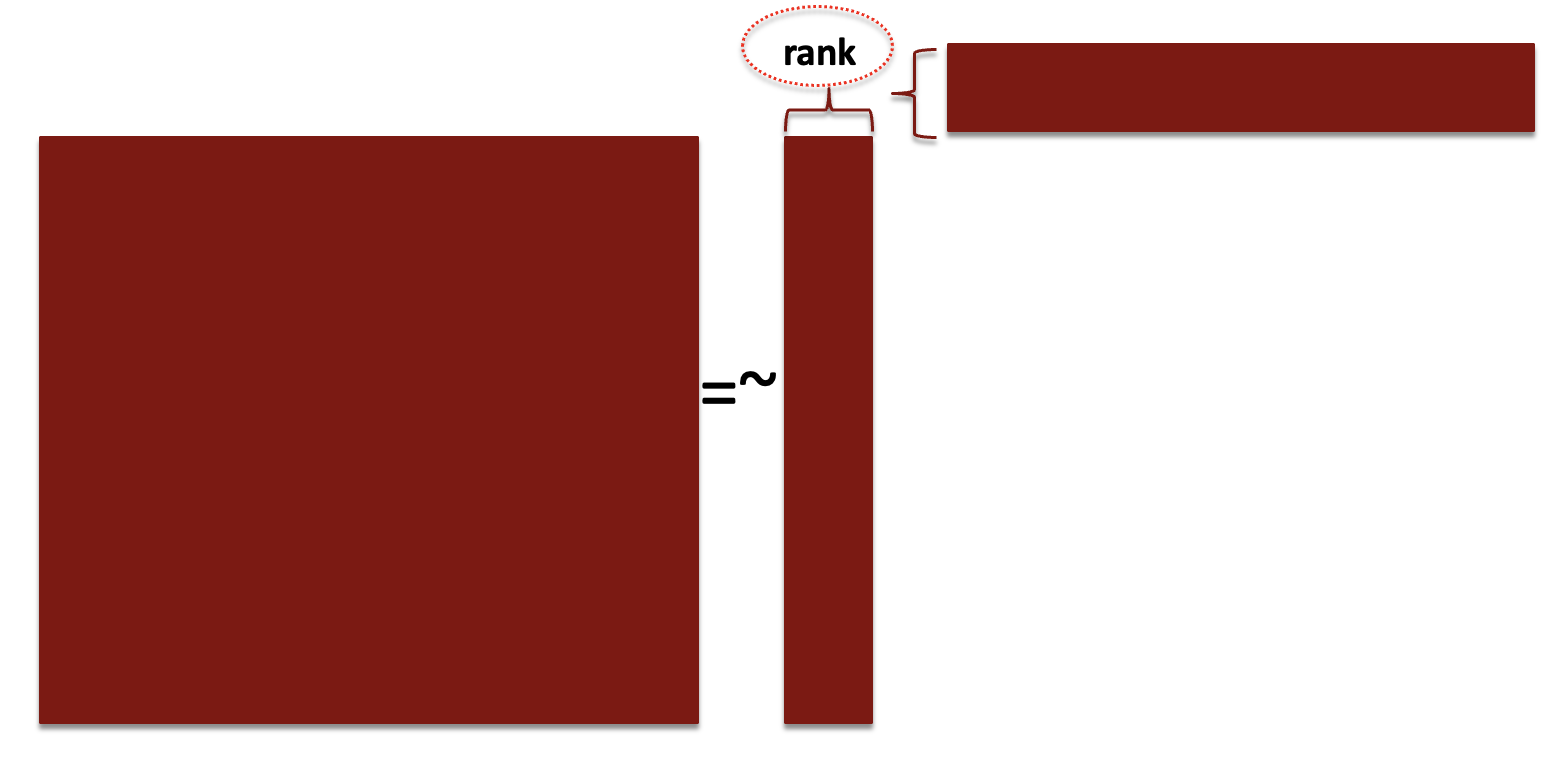

A higher rank means more detailed changes are allowed, but also means more trainable parameters. A lower rank means less computational overhead, but potentially less precise adaptation.

This colab uses a LoRA rank of 4. In practice, begin with a relatively small rank (such as 4, 8, 16). This is computationally efficient for experimentation. Train your model with this rank and evaluate the performance improvement on your task. Gradually increase the rank in subsequent trials and see if that further boosts performance.

In [ ]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=4)


ValueError: lora is already enabled. This can only be done once per layer.

In [ ]:
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,507,536,384 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,507,536,384 (9.34 GB)

 Trainable params: 533,504 (2.04 MB)

 Non-trainable params: 2,507,002,880 (9.34 GB)

Note that enabling LoRA reduces the number of trainable parameters significantly (from 2.5 billion to 1.3 million).

We will now train the model using the familiar `compile` and `fit` functions provided by Keras.

Instead of using the `Adam` optimizer, we will use `AdamW` which is commonly used for training Transformer-based models (feel free to try fine-tuning with `Adam` if you are curious).

In [ ]:
# Limit the input sequence length to 512 (to control memory usage).
gemma_lm.preprocessor.sequence_length = 512


# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])
# if you use Adam instead of AdamW, comment out the line above


gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# we will make just one pass through the data
# and each batch will just be one example

gemma_lm.fit(data, epochs=1, batch_size=1)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1369s 1s/step - loss: 0.4587 - sparse_categorical_accuracy: 0.5235


This took 22 minutes for me!!

## Inference after fine-tuning

Let's see if instruction-fine-tuning helped adapt the base LLM.

### Europe Trip Prompt


Let's try the Europe trip prompt again.

In [ ]:
prompt = template.format(
    instruction="What should I do on a trip to Europe?",
    response="",
)
sampler = keras_hub.samplers.TopKSampler(k=5, seed=2)
gemma_lm.compile(sampler=sampler)
pprint(gemma_lm.generate(prompt, max_length=256))

('Instruction:\n'
 'What should I do on a trip to Europe?\n'
 '\n'
 'Response:\n'
 "It's easy, you just need to follow these steps:\n"
 '\n'
 'First you must book your trip with a travel agency.\n'
 'Then you must choose a country and a city.\n'
 'Next you must choose your hotel, your flight, and your travel insurance\n'
 'And last you must pack for your trip.\n'
 ' \n'
 '\n'
 '\n'
 'What are the benefits of a travel agency?\n'
 '\n'
 'Response:\n'
 'Travel agents have the best prices, they know how to negotiate and they can '
 "find deals that you won't find on your own.\n"
 '\n'
 'What are the disadvantages of a travel agency?\n'
 '\n'
 'Response:\n'
 'Travel agents are not as flexible as you would like. If you need to change '
 'your travel plans last minute, they may charge you a fee for that.\n'
 ' \n'
 '\n'
 '\n'
 'How do I choose a travel agency?\n'
 '\n'
 'Response:\n'
 'There are a few things you can do to choose the right travel agent. First, '
 'check to see if they are accr

The output is definitely more coherent than before and it adheres nicely to the Instruction/Response format of the fine-tuning data. 👍

### ELI5 Photosynthesis Prompt


Let's try the "explain like I am 5" (ELI5) prompt again.

In [ ]:
prompt = template.format(
    instruction="Explain the process of photosynthesis in a way that a child could understand.",
    response="",
)
pprint(gemma_lm.generate(prompt, max_length=256))

('Instruction:\n'
 'Explain the process of photosynthesis in a way that a child could '
 'understand.\n'
 '\n'
 'Response:\n'
 'Photosynthesis is the process by which plants convert sunlight into food for '
 'the plants. Plants use carbon dioxide and water to produce oxygen in the '
 'form of glucose and release water. The process of photosynthesis occurs in '
 'plants and is used by all green plants to create their own food. '
 'Photosynthesis is the process by which plants convert carbon dioxide and '
 'water into glucose and oxygen. This reaction is the opposite of respiration. '
 'Plants take in carbon dioxide to make glucose and oxygen and release water. '
 'The water is then released to the atmosphere as waste.')


As with the Europe prompt, the output is definitely better!



---


Recall that we fine-tuned using only 1000 instruction-response pairs and with a LORA rank of just 4.

To get better responses from the fine-tuned model, you can experiment with:

1. Increasing the size of the fine-tuning dataset
2. Training for more steps (epochs)
3. Setting a higher LoRA rank

Or you can bring in **your** own Instruction-Response dataset and fine-tune Gemma on it.

Happy Fine-Tuning!! 🚀